In [ ]:
1. 동전 이미지를 이용한 윤곽선 -> 물체 구분하기 (사람이 몇 명인지 등)
   opencv (이미지 검출, 히스토그램, 레이블 지정 등)

2. 이미지 영상 + CNN 기법 접목
 - 데이터를 학습 데이터로 로드
 - 데이터를 늘이는 방법
 - 데이터를 생성하는 방법

3. 학습, 예측률 

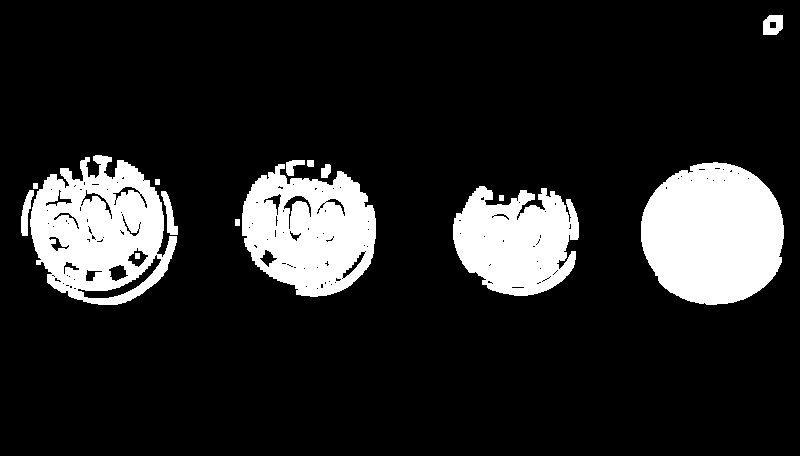

In [5]:
# 동전이미지 윤곽 분리하는 방법 : cv2.watershed() -> 라벨을 바탕으로 윤곽 추출
# 흑백으로 가져와서 -> 이진화 진행 -> 노이즈 제거
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

def imshow(img):
    ret, encoded = cv2.imencode('.png', img)
    display(Image(encoded))
    
img = cv2.imread('coin01.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 이진화 작업
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 노이즈 제거
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
imshow(bin_img)

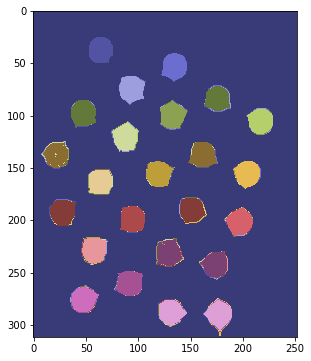

In [49]:
# 동전이미지 윤곽 분리하는 방법 : cv2.watershed()
# 흑백으로 가져와서 -> 이진화 진행 -> 노이즈 제거 -> sure background 인식, 추출
# 겹쳐있는 경우 sure backgroud 필수 진행
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

def imshow(img):
    ret, encoded = cv2.imencode('.jpg', img)
    display(Image(encoded))
    
img = cv2.imread('coin02.jpg')
# img = cv2.imread('saram.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 이진화 작업
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 노이즈 제거
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
# imshow(bin_img)

# sure Background 추출 : cv2.dilate()
# 대상을 그룹화 -> 배경과 그룹을 분리
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
# imshow(sure_bg)

# 거리 구하기
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
# imshow(dist)

# 그룹화된 대상들 분리
ret, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
# imshow(sure_fg)

# 분리한 위치(=동전의 위치), 배경인지 대상인지 구분
unknow = cv2.subtract(sure_bg, sure_fg)
# imshow(unknow)

# 레이블 0 : 대상 또는 배경인지 모르는 경우
# 레이블 1 : 배경
# 레이블 2 : 대상 (물체, ex.동전)
# 레이블 설정 cv2.connectedComponents()
ret, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers [unknow == 255 ] = 0

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(markers, cmap='tab20b')
plt.show()

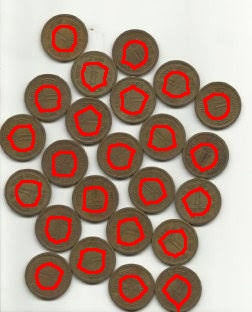

In [50]:
# watershed 알고리즘을 이용해서 윤곽선 추출
labels = np.unique(markers)  # 0~25까지 출력 확인
coins = []
for label in labels[2:] :  # 0(배경),1(경계)을 제외하고 2(대상)부터
    target = np.where(markers == label, 255,0 ).astype(np.uint8)
#     print(target)
    # 윤곽추출
    cnt, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(cnt[0])

# 그리기
cv2.drawContours(img, coins, -1, color=(0,0,255), thickness=2)
imshow(img)

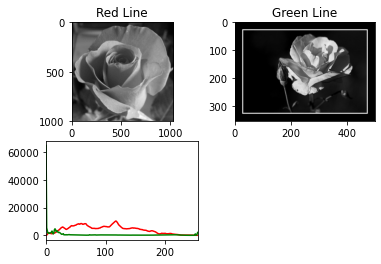

In [56]:
# 히스토그램 : 이미지 밝기의 분포를 표시
# 채도를 확인할 수 있음
import cv2 
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('flower1.jpg',0)
img2 = cv2.imread('flower2.jpg',0)

hist1 = cv2.calcHist([img1], [0], None, [256], [0,256])
hist2 = cv2.calcHist([img2], [0], None, [256], [0,256])

plt.subplot(221),plt.imshow(img1, 'gray'), plt.title('Red Line')
plt.subplot(222),plt.imshow(img2, 'gray'), plt.title('Green Line')
plt.subplot(223),plt.plot(hist1, color= 'r'), plt.plot(hist2, color='g')
plt.xlim([0,256])
plt.show()


In [72]:
# 2. 데이터 이미지 늘리는 방법
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = 'C:\\test'
img_name = 'dog10.jpg'
save_dir = os.path.join(data_dir,'preview') # 저장할 디렉토리

# 재량껏 이미지 속성 지정
datagen = ImageDataGenerator( rotation_range=40, width_shift_range=0.2,
                            height_shift_range=0.2, shear_range=0.2,
                            zoom_range=0.2, fill_mode='nearest',
                            horizontal_flip=True)
im_array = cv2.imread(os.path.join(data_dir, img_name))  # 이미지 로드
# print(im_array)
 
# 차원 변환 
im_array = im_array.reshape((1,) + im_array.shape) # 4차원으로 변환
# print(im_array)

# 경로가 없을 경우 생성
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

i = 0
# 이미지 배치
for batch in datagen.flow(
    im_array, batch_size=1, save_to_dir=save_dir, save_prefix='dog',
    save_format='jpg' ) :
    i += 1
    if i == 10 :
        break
        

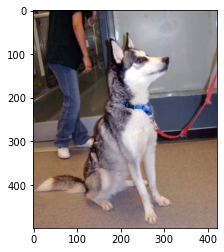

In [77]:
# 2. 이미지 영상 + CNN 기법 접목
# 2-1. 이미지는 폴더명으로 카테고리를 분류하고 이미지 로드
import matplotlib.pyplot as plt
import os
import cv2

datadir='C:\\petImage'
categoris=['dogs','cats']

# 이미지 1개 로드
for category in categoris:
    path = os.path.join(datadir,'test_set',category)
    for image_name in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, image_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)
        plt.show()
        break
    break

학습 데이터 레이블 :  0
학습 데이터 레이블 :  0
학습 데이터 레이블 :  1
학습 데이터 레이블 :  0


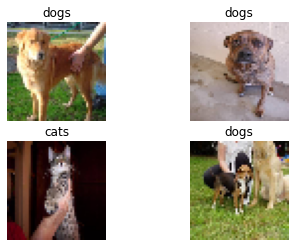

In [86]:
# 2. 이미지 영상 + CNN 기법 접목
# 2-1. 이미지는 폴더명으로 카테고리를 분류하고 이미지 로드
# 2-2. 이미지 크기 조정 -> 레이블 추가 -> numpy 배열로 변환
import matplotlib.pyplot as plt
import os
import cv2
import random

datadir='C:\\petImage'
categoris=['dogs','cats']
training_data = []
img_size=50

def create_training_data():
    for class_num, category in enumerate(categoris):
        path = os.path.join(datadir,'test_set',category)
        for image_name in os.listdir(path):
            try:  # 이미지 로드, 크기 조절, 데이터 레이블 정보 추가
                img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
#                 img_array = cv2.imread(os.path.join(path, image_name))  # color 경우
                img_resize_array = cv2.resize(img_array, (img_size,img_size))
                training_data.append([ img_resize_array, class_num ])
            except Exception as e:
                pass
        
create_training_data()
random.shuffle(training_data)

X_train=[]  # 이미지 데이터
y_train=[]  # 레이블 정보

# 데이터 셋 설정
for feature, label in training_data :
    X_train.append(feature)
    y_train.append(label)

# numpy 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

# 데이터 셋 확인
for i in range(0,4):
    print('학습 데이터 레이블 : ', y_train[i])
    plt.subplot(2,2, i+1)
    plt.axis('off')
    plt.title(label='dogs' if y_train[i] == 0 else 'cats')
    plt.imshow(X_train[i], cmap='gray')
    
    # color로 보고싶은 경우
#     img_array = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)
#     plt.imshow(img_array)
    

In [92]:
# 모델 생성
from keras import layers
from keras import models
from keras import optimizers

# 순자 모델 생성
model = models.Sequential()

# Convolusion 세트4개 -> Conv2D
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# 1차원으로 생성
model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

# 출력, 레이블이 두개중에 하나여서 sigmoid 사용
model.add(layers.Dense(1, activation='sigmoid'))

# 확인
model.summary()

# 컴파일
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [96]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import extra_keras_datasets.emnist as emnist
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
!pip install extra_keras_datasets

ModuleNotFoundError: No module named 'extra_keras_datasets'

In [97]:
!pip install extra_keras_datasets